# COMP5329 Assignment2

## Yujun Liu 480422097         
## Yueying Sun 470169265              
## Dongqi Xu 480529282

## Download file from Goolge drive into colab

In [1]:
# Code to download file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

     |████████████████████████████████| 993kB 9.1MB/s 


In [0]:
id = '1cLKpcZS-P9TCLO0X1xw2p5ZLIwPuzErM'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('test.tar.gz')  

id = '1ZZ_xgbVMEVuX6NxvpFIk8fWwl5rrvKh0'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('train.tar.gz')  

id = '11opV9N2wI4rcpv5QcsNY2clVgN-IWA7_'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('train.txt')  

## Load all required libraries

In [0]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dense, Activation, Convolution2D, MaxPooling2D, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.python.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from PIL import Image
import time
import math
import pandas as pd
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import numpy as np
from IPython.display import display, Image

## Decompress tar files

In [0]:
import os
import tarfile
tar = tarfile.open("train.tar.gz")
names = tar.getnames()
for name in names:
    tar.extract(name, path = "/content/")
tar.close()

## A glimpse of datasets

['train2014/0.jpg', 'train2014/1.jpg', 'train2014/2.jpg', 'train2014/3.jpg']
31925
(214, 320, 3)


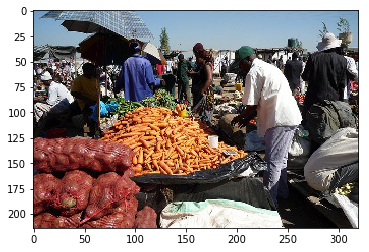

(214, 320, 3)
(214, 320, 3)
(240, 320, 3)
(320, 214, 3)
(213, 320, 3)


In [5]:
name_list = []
with tarfile.open("train.tar.gz", "r") as file:
    for i in file.getmembers():
        name_list.append(i.name)
print(name_list[1:5])
print(len(name_list[1:]))

I = mpimg.imread('train2014/0.jpg')
#print(I)
## Decompress tar files
print(I.shape)

plt.imshow(I)
plt.show()

for i in range(5):
  I = mpimg.imread(name_list[i+1])
  print(I.shape)

## encoder the labels

In [6]:
label_file = np.loadtxt("train.txt", dtype=bytes)
np.random.shuffle(label_file)
label_file[0:5]

array([[b'20875.jpg', b'4'],
       [b'7308.jpg', b'6'],
       [b'1527.jpg', b'4'],
       [b'13304.jpg', b'18,4'],
       [b'8235.jpg', b'14']], dtype='|S15')

In [0]:
label_0 = label_file[:,0].astype(str)
label_1 = label_file[:,1].astype(str)

new_arr = np.append(label_0.reshape(-1,1),label_1.reshape(-1,1), axis = 1)
import pandas as pd 
df = pd.DataFrame(new_arr,columns = ['Filenames', 'labels'])

df["labels"] = df["labels"].apply(lambda x: list(map(int, x.split(","))))

In [8]:
df[:5]

,Filenames,labels
0,20875.jpg,[4]
1,7308.jpg,[6]
2,1527.jpg,[4]
3,13304.jpg,"[18, 4]"
4,8235.jpg,[14]


## make several image-generators for training, testing and predicting stages

In [0]:
# define a function for generators, the function is to do zero-mean on image's arrays 
def myFunc(image):

    x = preprocess_input(image)
    
    return x

In [0]:
image_size = 224
train_dir = "train2014"

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        #zca_epsilon=1e-06,
        #rotation_range=30,
        #width_shift_range=0.1,        
        #height_shift_range=0.1,        
        shear_range=0.,        
        #zoom_range=0.05,        
        #channel_shift_range=0.,        
        fill_mode='nearest',
        cval=0.,
        horizontal_flip=True,
        vertical_flip=True,
        rescale = None,
        preprocessing_function=myFunc,
        data_format=None
        )


validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
       rescale = None,
       preprocessing_function=myFunc
       )

In [11]:
batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
    dataframe = df[0:25540],
    directory = train_dir,
    x_col = 'Filenames',
    has_ext = True,
    y_col = 'labels',
#     subset = "training",
    batch_size = batch_size,
    seed = 42,
    shuffle = True,
    classes = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19],
    class_mode = 'categorical',
    target_size = (image_size, image_size)
    )


val_generator = validation_datagen.flow_from_dataframe(
    dataframe = df[25540:],
    directory = train_dir,
    x_col = 'Filenames',
    has_ext = True,
    y_col = 'labels',
#     subset = "validation",
    batch_size = batch_size,
    seed = 42,
#     shuffle = True,
    class_mode = 'categorical',
    target_size = (image_size, image_size)
    )

Found 25540 images belonging to 20 classes.
Found 6385 images belonging to 20 classes.


##  build the sequential model

In [0]:
base_model = ResNet50(include_top=False,
                         input_shape=(224, 224, 3),
                         weights='imagenet',)

#freeze the layers of Resnet50 to maintain the pretrained embedding parameters
base_model.trainable = False

dense_layer1 = keras.layers.Dense(1024, activation='relu')
BN1 = keras.layers.BatchNormalization(axis=-1, momentum=0.99)
DRP1 = keras.layers.Dropout(rate=0.5)
dense_layer4 = keras.layers.Dense(512, activation='relu')
dense_layer2 = keras.layers.Dense(128, activation='relu')
BN2 = keras.layers.BatchNormalization(axis=-1, momentum=0.99)
DRP2 = keras.layers.Dropout(rate=0.5)
dense_layer3 = keras.layers.Dense(20, activation='sigmoid')
flatten = keras.layers.Flatten()
pooling = tf.keras.layers.GlobalAveragePooling2D()


model = tf.keras.Sequential([
    base_model,
    pooling,
    dense_layer4,
    BN1,
    dense_layer2,  
    BN2,
    dense_layer3
])

model.summary()

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_6 ( (None, 2048)              0         
_________________________________________________________________
dense_25 (Dense)             (None, 512)               1049088   
_________________________________________________________________
batch_normalization_v1_12 (B (None, 512)               2048      
_________________________________________________________________
dense_26 (Dense)             (None, 128)               65664     
_________________________________________________________________
batch_normalization_v1_13 (B (None, 128)               512       
_________________________________________________________________
dense_27 (Dense)             (None, 20)                2580      
Total para

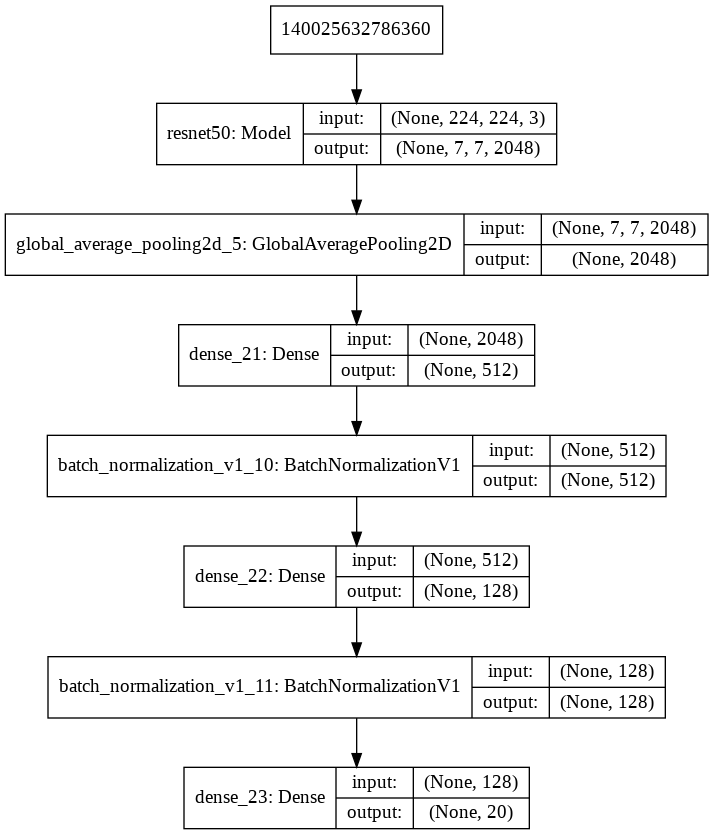

In [0]:
plot_model(model, to_file='Graph.png', show_shapes=True)
# display graph
display(Image(filename='Graph.png'))

## Compile the model 

In [0]:
import functools
top1_acc = functools.partial(tf.keras.metrics.top_k_categorical_accuracy,k=1)
top1_acc.__name__='top1_acc'

In [0]:
model.compile(optimizer = 'Rmsprop',loss='binary_crossentropy', metrics = [top1_acc])
#model.compile(optimizer = 'Nadam',loss='categorical_crossentropy', metrics = [top1_acc])

In [0]:
steps_per_epoch = train_generator.n // batch_size
validation_steps = val_generator.n // batch_size
history = model.fit_generator(train_generator, 
                              epochs = 5, 
                              steps_per_epoch = steps_per_epoch,
                              validation_data = val_generator, 
                              validation_steps= validation_steps, 
                              verbose = 1)

Epoch 1/5
799/799 [==============================] - 164s 206ms/step - loss: 0.1025 - top1_acc: 0.6219 - val_loss: 0.1112 - val_top1_acc: 0.6140
Epoch 2/5
799/799 [==============================] - 161s 201ms/step - loss: 0.0988 - top1_acc: 0.6384 - val_loss: 0.1119 - val_top1_acc: 0.6204
Epoch 3/5
799/799 [==============================] - 161s 201ms/step - loss: 0.0969 - top1_acc: 0.6419 - val_loss: 0.1140 - val_top1_acc: 0.6193
Epoch 4/5
799/799 [==============================] - 163s 204ms/step - loss: 0.0956 - top1_acc: 0.6480 - val_loss: 0.1152 - val_top1_acc: 0.6211
Epoch 5/5
799/799 [==============================] - 162s 203ms/step - loss: 0.0931 - top1_acc: 0.6556 - val_loss: 0.1168 - val_top1_acc: 0.6122


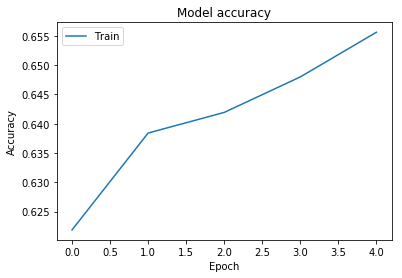

In [0]:
plt.plot(history.history['top1_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

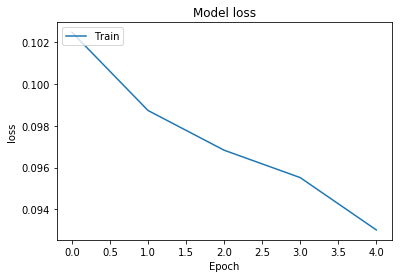

In [0]:
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## See the validation test accuracy

In [0]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=myFunc)

test_generator = test_datagen.flow_from_dataframe(
    dataframe = df[25540:],
    directory = train_dir,
    x_col = 'Filenames',
    has_ext = True,
    y_col = 'labels',
    batch_size = 32,
    seed = 42,
    shuffle = False,
    class_mode = 'categorical',
    target_size = (224, 224)
    )

#test_generator.reset()

Found 6385 images belonging to 20 classes.


In [0]:
y_pre_cat = model.predict_generator( test_generator )

y_pred = np.argmax(y_pre_cat, axis=1)
y_true = df[25540:]["labels"].values


count = 0
for i in range(y_pred.shape[0]):
    if y_pred[i] in y_true[i]:
        count += 1
print(count/y_pred.shape[0])

# y_pre_cat = model.predict_generator( train_generator )

0.7035238841033673


In [0]:
#  for i in range(len(y_pred)):
#  print(y_pred[i],y_true[i],df.iloc[i])

## Predict and store labels for test data

In [0]:
import os
import tarfile
tar1 = tarfile.open("test.tar.gz")
names1 = tar1.getnames()
for name in names1:
    tar1.extract(name, path = "/content/")
tar1.close()

In [0]:
len(names1)

15517

In [0]:
result = []
for i in names1[1:]:
    img_path = i
    img = image.load_img(i, target_size=(224, 224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)

    img = preprocess_input(img)

    pre = model.predict(img)
    pred = np.argmax(pre, axis=1)
    result.append(pred[0])
result[:10] 

[6, 8, 6, 13, 6, 16, 3, 19, 6, 19]

In [0]:
len(result)

15516

In [0]:

fw = open("Predicted_labels.txt", 'w')   
 
for i in range(len(result)):
    a = str(names1[i+1])+str(" ")+str(result[i])
    fw.write(a)
    fw.write("\n")
fw.close()

In [0]:
#import numpy as np
#import h5py

#f = h5py.File('predicted_labels.h5', 'w')
   
#f['image'] = np.string_(names1[1:])
#f['labels'] = result          
#f.close() 

#ff = h5py.File('predicted_labels.h5','r')
#ff['image'][:]
#ff['labels'][:]

## store the model and its parameters


In [0]:
model.save("my_model.h5")  # creates a HDF5 file 'my_model.h5'

## Method 2 :  A completely self-built CNN model 

In [15]:
model2 = Sequential()
model2.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=(224,224,3)))
model2.add(Activation('relu'))
model2.add(Conv2D(32, (3, 3)))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))
model2.add(Conv2D(64, (3, 3), padding='same'))
model2.add(Activation('relu'))
model2.add(Conv2D(64, (3, 3)))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))
model2.add(Flatten())
model2.add(Dense(512))
model2.add(Activation('relu'))
model2.add(Dropout(0.5))
model2.add(Dense(20, activation='sigmoid'))
model2.compile(optimizer = 'adam',loss='binary_crossentropy', metrics = [top1_acc])
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
activation_5 (Activation)    (None, 224, 224, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 222, 222, 32)      9248      
_________________________________________________________________
activation_6 (Activation)    (None, 222, 222, 32)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 111, 111, 64)      18496     
__________

In [16]:
steps_per_epoch2 = train_generator.n // batch_size
validation_steps2 = val_generator.n // batch_size
history2 = model2.fit_generator(train_generator, 
                     epochs = 10, 
                     steps_per_epoch = steps_per_epoch2,
                     validation_data = val_generator, 
                     validation_steps= validation_steps2, 
                     verbose = 1)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
799/799 [==============================] - 167s 209ms/step - loss: 1.2521 - top1_acc: 0.7437 - val_loss: 1.0371 - val_top1_acc: 1.0000
Epoch 2/10
799/799 [==============================] - 162s 203ms/step - loss: 1.3336 - top1_acc: 0.6560 - val_loss: 1.0374 - val_top1_acc: 1.0000
Epoch 3/10
799/799 [==============================] - 164s 205ms/step - loss: 1.3365 - top1_acc: 0.6532 - val_loss: 1.0374 - val_top1_acc: 1.0000
Epoch 4/10
799/799 [==============================] - 162s 203ms/step - loss: 1.1842 - top1_acc: 0.8049 - val_loss: 1.0371 - val_top1_acc: 1.0000
Epoch 5/10
799/799 [==============================] - 163s 204ms/step - loss: 1.2187 - top1_acc: 0.7461 - val_loss: 1.0371 - val_top1_acc: 1.0000
Epoch 6/10
799/799 [==============================] - 162s 203ms/step - loss: 1.1963 - top1_acc: 0.7732 - val_loss: 1.0371 - val_top1_acc: 1.0000
Epoch 7/10
799/799 [==============================] - 164s 205ms/step - loss

In [17]:
test_generator2 = validation_datagen.flow_from_dataframe(
    dataframe = df[25540:],
    directory = train_dir,
    x_col = 'Filenames',
    has_ext = True,
    y_col = 'labels',
    batch_size = 32,
    seed = 42,
    shuffle = False,
    class_mode = 'categorical',
    target_size = (image_size, image_size)
    )

test_generator2.reset()

Found 6385 images belonging to 20 classes.


In [18]:
y_pre_cat2 = model2.predict_generator( test_generator2 )

y_pred2 = np.argmax(y_pre_cat2, axis=1)
y_true2 = df[25540:]["labels"].values


count = 0
for i in range(y_pred2.shape[0]):
    if y_pred2[i] in y_true2[i]:
        count += 1
print(count/y_pred2.shape[0])

0.057008613938919345


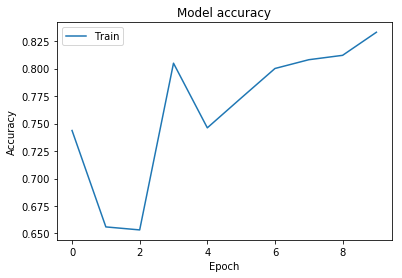

In [19]:
plt.plot(history2.history['top1_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

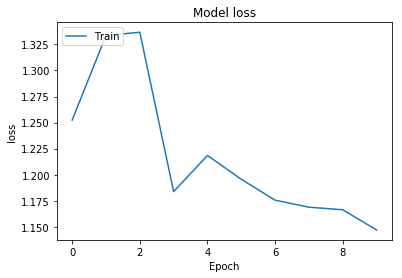

In [20]:
plt.plot(history2.history['loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()